# EDA: Synthetic Dataset

해당 데이터셋은 인공적으로 만들어진 ECG와 PPG 신호를 제공한다. 이 신호들은 연구자들의 알고리즘이 이상적인 데이터에서 호흡수를 정확하게 평가하는지 확인하기 위해 생성되었다.

알고리즘이 합리적으로 구현되었는지 확인할 때 특히 유용하다. 본 데이터셋은 다양한 심박수(HR)과 호흡수(RR)를 아우르는 ECG, PPG 신호를 포함한다. 

각각의 HR과 RR에 대해 세 가지 신호 (Baseline wandering(BW), Amplitude modulation(AM), Frequency modulation(FM)) 가 선택적으로 조합되어 제공된다.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import multiprocessing
from scipy import signal
from itertools import starmap
import matplotlib.pyplot as plt
from utils.signal_processing import signal_resample
%matplotlib inline
plt.style.use('ggplot')

DATALAKE_PATH = '../../DataLake/rrest-syn_csv'
regex = re.compile('rrest-syn[0-9]+')
syn_id = sorted(list(set([regex.match(filename.name).group() for filename in os.scandir(DATALAKE_PATH)])))
fs = 500

In [2]:
temp_resp = []
for i in range(len(syn_id)):
    with open(f'{DATALAKE_PATH}/{syn_id[i]}_fix.txt') as f:
        temp_resp.append(f.readlines()[-2])
    
temp_resp = np.asarray(temp_resp)

In [3]:
exp_resp = re.compile(r'\d+')
resp = list(map(lambda r: int(exp_resp.findall(r)[0]), temp_resp))

In [4]:
pleth = []
for i in range(len(syn_id)):
    sig_dat = pd.read_csv(f'{DATALAKE_PATH}/{syn_id[i]}_data.csv', header=None, names=['PLETH', 'ECG'])
    pleth.append(sig_dat.PLETH.values[500:60500]) # 성모병원도 약 2분 데이터이므로

pleth = np.asarray(pleth)
print(pleth.shape, len(resp))

(192, 60000) 192


In [5]:
pool = multiprocessing.Pool(processes=40)
pleth125 = pool.starmap(signal_resample, [(p, 500, 125) for p in pleth])
pool.close()
pool.join()

In [10]:
np.asarray(pleth125).shape

(192, 15000)

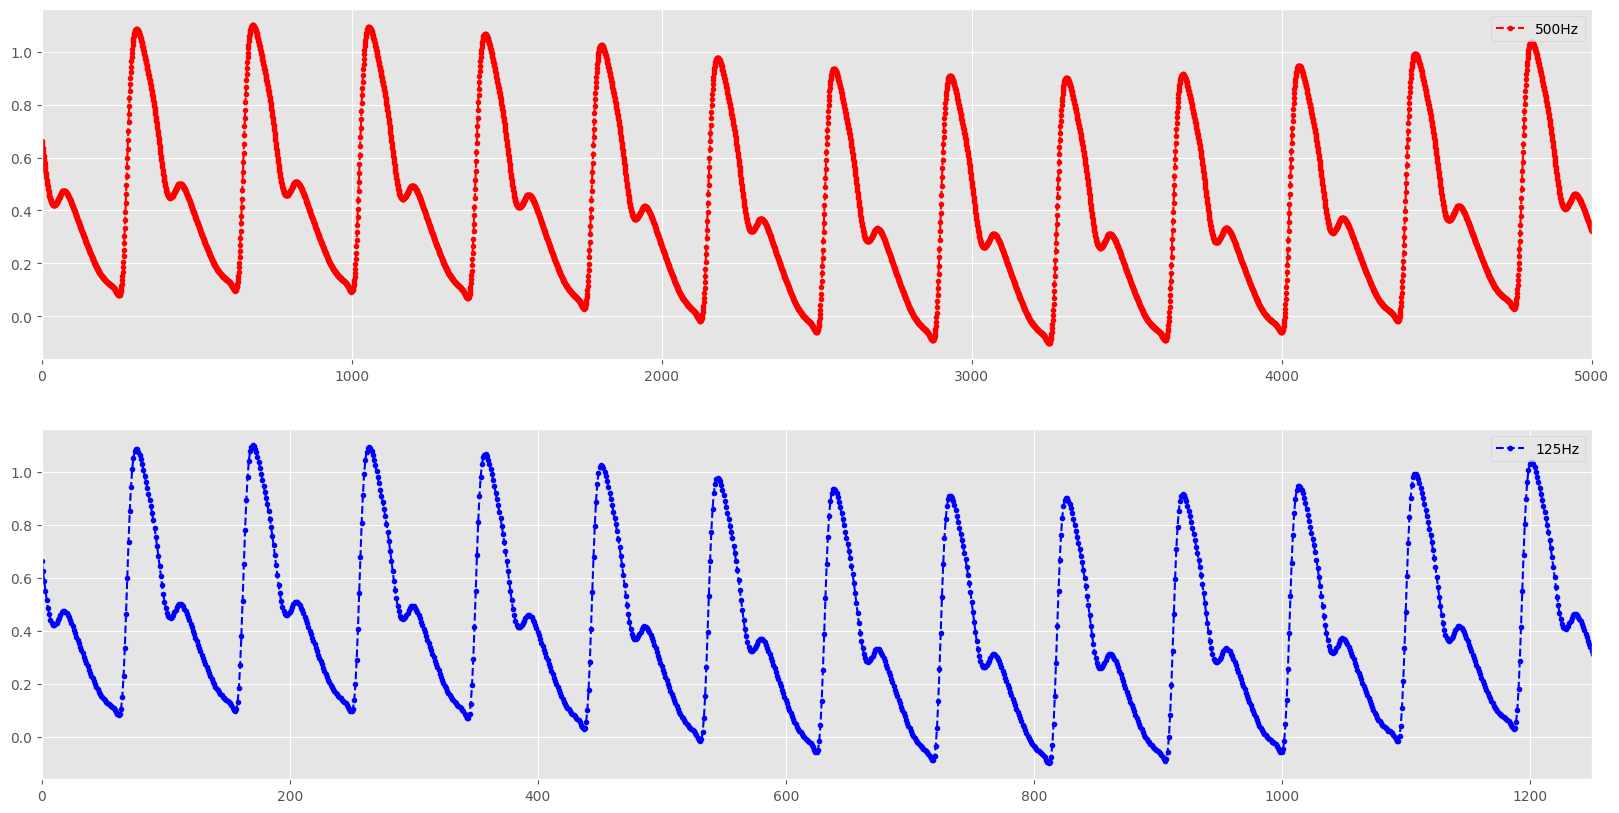

In [7]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(pleth[1], linestyle='--', marker='o', markersize=3, color='r', label='500Hz')
axs[0].set_xlim(0, 5000)
axs[0].legend()
axs[1].plot(pleth125[1], linestyle='--', marker='o', markersize=3, color='b', label='125Hz')
axs[1].set_xlim(0, 1250)
axs[1].legend()
plt.show()

## Filtering

took 2m 35s

In [8]:
# Filtering
taps = signal.firwin(numtaps=400, cutoff=[0.5, 8.0], window='hamming', pass_zero=False, fs=125)
w, h = signal.freqz(taps)

pool = multiprocessing.Pool(processes=40)
filtered_pleth = pool.starmap(signal.filtfilt, [(taps, 1.0, p) for p in pleth125])
pool.close()
pool.join()
filtered_pleth = np.asarray(filtered_pleth)

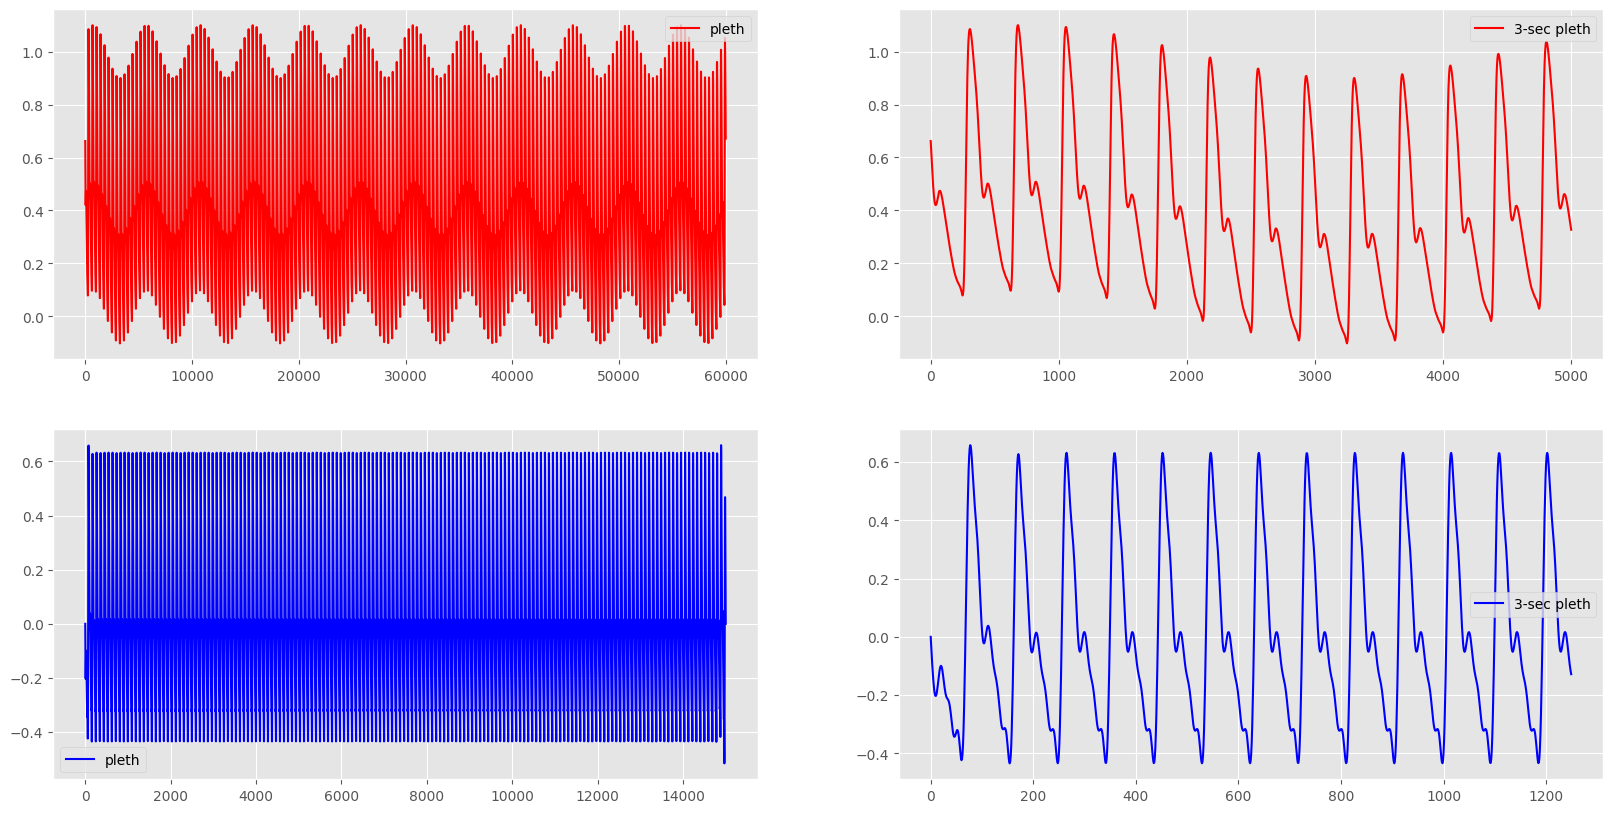

In [12]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].plot(pleth[1], label='pleth', color='r')
axs[0][0].legend()
axs[0][1].plot(pleth[1][0:500*10], label='3-sec pleth', color='r')
axs[0][1].legend()
axs[1][0].plot(filtered_pleth[1], label='pleth', color='b')
axs[1][0].legend()
axs[1][1].plot(filtered_pleth[1][0:125*10], label='3-sec pleth', color='b')
axs[1][1].legend()
plt.show()

## Windowing

In [15]:
filtered_pleth.shape

(192, 15000)

In [17]:
# Windowing
fs = 125
dataset = []
shift_factor = 4
window_size = fs * 60 # 125*60=7500
shift = int(window_size/shift_factor) # 1875
samples_len = len(filtered_pleth) # 196    

shift_n_times = int((filtered_pleth.shape[1]-window_size)/shift)
new_resp = np.repeat(resp, shift_n_times) # 192 * 4

for i in range(samples_len):
    sliced_pleth = [filtered_pleth[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]
    matched_resp = [resp[i]] * shift_n_times

    for i in range(shift_n_times):
        temp = []
        temp.append(sliced_pleth[0][i])
        temp.append(matched_resp[i])
        dataset.append(temp)

len(dataset) # 192*7 PLETH-RESP

768

## Resampling

In [18]:
# Resampling
pool = multiprocessing.Pool(processes=40)
result = pool.starmap(signal_resample, [(pleth, 125, 30) for pleth, _ in dataset])
pool.close()
pool.join()

In [19]:
new_patient = []
for i in range(len(dataset)):
    resp = dataset[i][1]
    resampled_pleth = result[i]
    
    temp = []
    temp.append(resampled_pleth)
    temp.append(resp)
    new_patient.append(temp)

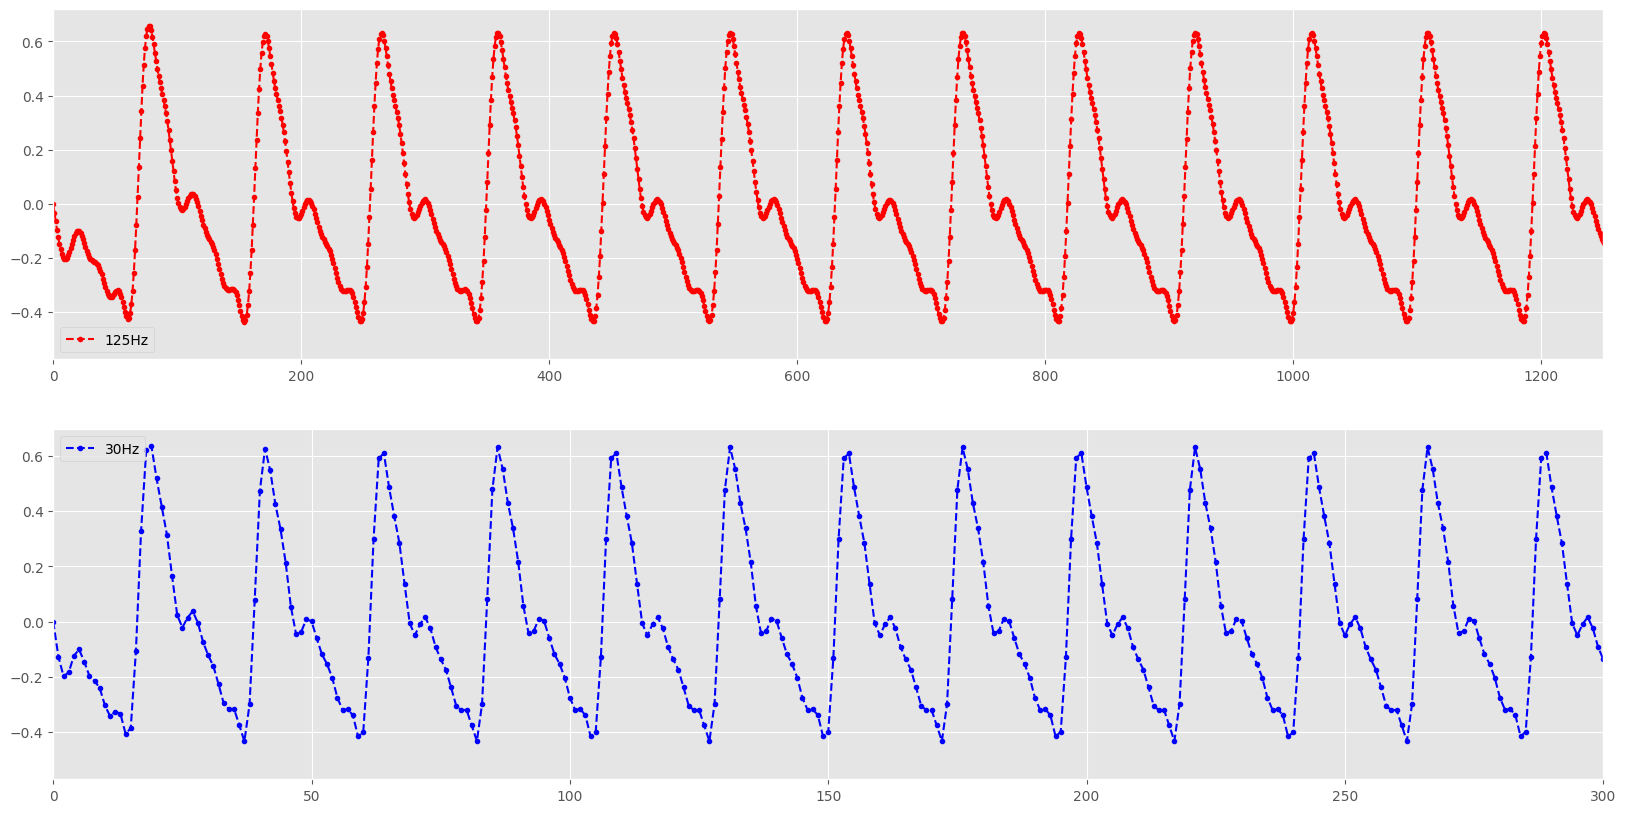

In [21]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(dataset[1][0], linestyle='--', marker='o', markersize=3, color='r', label='125Hz')
axs[0].set_xlim(0, 1250)
axs[0].legend()
axs[1].plot(new_patient[1][0], linestyle='--', marker='o', markersize=3, color='b', label='30Hz')
axs[1].set_xlim(0, 300)
axs[1].legend()
plt.show()

---

In [9]:
test = pd.read_csv(f'{DATALAKE_PATH}/{syn_id[1]}_data.csv', header=None, names=['PLETH', 'ECG'])
test.shape

(105000, 2)

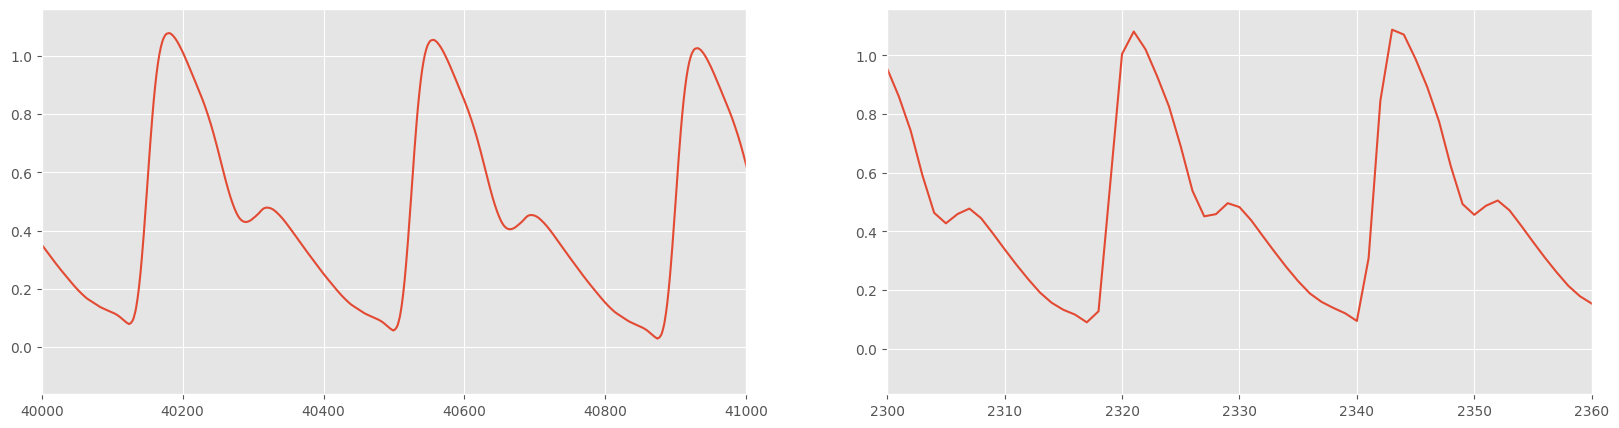

In [4]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(test.PLETH.values)
axs[0].set_xlim(40000, 41000)
axs[1].plot(signal_resample(test.PLETH.values, org_fs=500, new_fs=30, method='interpolation'))
axs[1].set_xlim(2300, 2360)
plt.show()